Generate my own data $x_i \sim \mbox{Gamma}(\alpha=1.5, \beta=60)$ and check that my method recover this. Use fairly few samples, and use only one term in $\alpha$ and $\beta$ polynomials. No need to transform from $\ell \to x$, we generate in $x$ directly

In [1]:
import Distributions, LaTeXStrings,optim, Plots, PyCall, Asymptotic

In [2]:
font = Plots.font("TeX Gyre Heros")
myfonts = Dict(:guidefont=>font,
:xtickfont=>font, :ytickfont=>font, :legendfont=>font);
Plots.pyplot(guidefont=font, xtickfont=font, ytickfont=font, legendfont=font)

Plots.PyPlotBackend()

In [307]:
α0 = 1.5; β0 = 60.
νmin=0.
νmax=10.

10.0

Do we need to make up frequencies? Not really, we just care about one bin, but for compatibility, we do

In [308]:
# define order of linear models
αOrder = 1
βOrder = 1
npackets=100

# read in data from tardis and create posterior
dim = αOrder + βOrder
∇res, Hres = optim.allocations(dim)
frame, (P, ∇P!, HP!) = optim.problem(αOrder=αOrder, βOrder=βOrder, run=99, npackets=npackets);

# now change the energies
PyCall.@pyimport numpy.random as nprand
nprand.seed(1358)
PyCall.@pyimport scipy.stats as stats
dist0 = stats.gamma(α0, scale=1/β0)
# crucial: change frame in place, else optimization runs with old energies!
frame[:energies][:] = dist0[:rvs](size=length(frame[:energies]))
# Plots.histogram(frame[:energies])

# the observed number of packets in the bin
nmin=searchsortedfirst(frame[:nus], νmin)
nmax=searchsortedlast(frame[:nus], νmax)
n = nmax - nmin + 1
x = sum(frame[:energies][nmin:nmax])
n,x

# for testing
# n = 291
# x= 7.389999302674019

(70,2.029505516565166)

In [309]:
# compute the posterior mode to estimate the evidence
# start optimization at true values
@time maxP, posterior_mode, ret = optim.run_nlopt(frame, P, ∇P!, HP!,
    αOrder, βOrder, xtol_rel=1e-4, init=1.001*[α0, β0])
HP!(posterior_mode, Hres)
evidence = optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.008262 seconds (238.60 k allocations: 3.666 MB)
got 179.45025365698154 at [1.32798,45.7953] (returned XTOL_REACHED) and evidence 181.24888528654657


Asymptotic
------

We will use all samples to compute the mean and variance but then focus on one $\nu$ bin to get the prediction as above

In [310]:
#index = searchsortedfirst(frame[:nus], νmin)
#samples = frame[:energies][index:index+n+1]
samples = frame[:energies][nmin:nmax]
xmean, sumsqdiff = mean(samples), (n-1)*var(samples)
asymp_res = Asymptotic.uncertainty(n, xmean, sumsqdiff, 1.)
distasympt=Distributions.Normal(asymp_res[1], asymp_res[2])


Distributions.Normal(μ=1.920271343190712, σ=0.6031876791878792)

Sum over N
----

In [311]:
# compute the posterior mode to estimate the evidence
# start optimization at true values
@time maxP, posterior_mode, ret = optim.run_nlopt(frame, P, ∇P!, HP!,
    αOrder, βOrder, xtol_rel=1e-3, init=1.001*[α0, β0])
HP!(posterior_mode, Hres)
evidence = optim.laplace(maxP, Hres)
println("got $maxP at $(posterior_mode) (returned $ret) and evidence $evidence")

  0.004758 seconds (139.51 k allocations: 2.144 MB)
got 179.44991757271387 at [1.33187,46.0108] (returned XTOL_REACHED) and evidence 181.25494121904768


The mode matches the input values well

In [312]:
# the posterior mean with the normalized posterior
# predict at bin center
# ν, X, N
#pm = optim.PosteriorMean((νmax + νmin)/2, x, convert(Float64, n))
pm = optim.PosteriorMean(1.0, x, convert(Float64, n))
Pmean, ∇Pmean!, HPmean! = optim.targetfactory(frame, αOrder, βOrder, evidence=evidence, pm=pm)
@time maxPmean, mean_mode, ret = optim.run_nlopt(frame, Pmean, ∇Pmean!, HPmean!, αOrder, βOrder,
init=posterior_mode, xtol_rel=1e-6)
println("max of normalized posterior = $maxPmean at $(mean_mode), returned $ret")

# n, a
nb = optim.NegBinom(n, 1.);

  0.034753 seconds (663.78 k allocations: 10.195 MB, 14.45% gc time)
max of normalized posterior = -1.1634698982884544 at [1.34306,46.3235], returned XTOL_REACHED


The **mode comes out pretty much at the input values** 

In [313]:
# compute points from asymptotic approx.
points = collect(linspace(max( asymp_res[1] - 3asymp_res[2], 0.0), asymp_res[1] + 3asymp_res[2], 25))
#points = collect(linspace(max(x-4, 0.0), x+1, 25))
distn = stats.gamma(n*α0, scale=1/β0)
# points = collect(linspace(distn[:ppf](1e-6), dist0[:ppf](1-1e-6), 25))
results = zeros(points)
# skip X = 0, start at 2
for i in 2:length(points)
    pm.X = points[i]
    results[i] = optim.predict_small(frame, Pmean, ∇Pmean!, HPmean!, pm, αOrder, βOrder, posterior_mode,
    nb, optimize=false)
end

initial N=18
initial N=24
initial N=29
initial N=34
initial N=39
initial N=43
initial N=48
initial N=52
initial N=56
initial N=60
initial N=64
initial N=68
initial N=71
initial N=75
initial N=79
initial N=82
initial N=86
initial N=90
initial N=93
initial N=97
initial N=101
initial N=104
initial N=107
initial N=111


In [314]:
simp = tardis.simpson(points, results)
info("Simpson: normalization=$(simp[1]), mean=$(simp[2]), σ=$(simp[3])")
results /= simp[1]
transpose(results)

INFO: Simpson: normalization=0.6943076999664631, mean=1.396071242108856, σ=0.6109047199085044


1×25 Array{Float64,2}:
 0.0  4.36163e-9  7.88577e-7  …  0.00608292  0.00238201  0.000881525

Plot and compare
----


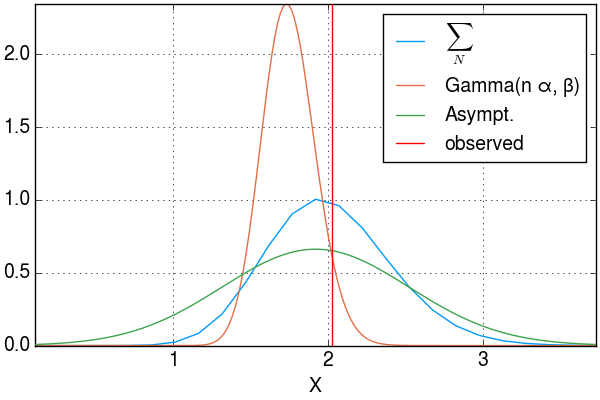

In [315]:
using LaTeXStrings, StatPlots
compare = function(points, results, x; distn=nothing, distasympt=nothing)
    Plots.plot(points, results, xlabel="X", label=L"\sum_N")
    finepoints = collect(linspace(points[1], points[end], 200))
    if distn !== nothing        
        Plots.plot!(finepoints, distn[:pdf](finepoints), label="Gamma(n α, β)")
    end
    if distasympt !== nothing
        Plots.plot!(finepoints, Distributions.pdf(distasympt, finepoints),
        label="Asympt.")
    end
    # vline at the end to plot all the way
    Plots.vline!([x], line=:red, label="observed")
end

compare(points, results, x; distn=distn, distasympt=distasympt)

In [316]:
n

70


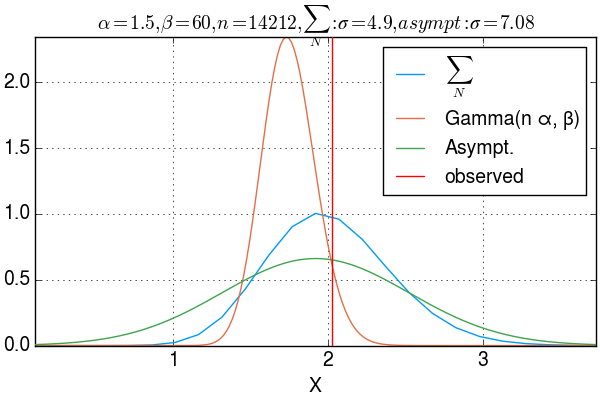

In [317]:
plot!(title=L"\alpha=1.5, \beta=60, n=14212, \sum_N: σ=4.9, asympt: σ=7.08", )
Plots.pdf("Qcompare-n14212")
plot!()

where does the variance come from
-----

If we use only 1000 instead of 10000 samples, prediction nearly identical $\Rightarrow$ broadening is due to the Poisson term

For compound Poisson,
$$V[Q] = V[X] \lambda + E[X^2] \lambda = \lambda E[X^2]$$

and for large $\lambda$, $\lambda \approx n$, so variance of compound 
$$V[Q] \propto n$$, so how well is Q known from $n$ samples? The usual answer
$$\sqrt{V[Q]}/Q \propto 1/\sqrt{n}$$

In [318]:
α0 / β0^2 * n, α0 / β0^2 *(1 + α0)

(0.029166666666666667,0.0010416666666666667)

Check optimizer
------

Is cobyla not working right?

In [319]:
using Optim

optimize(x->-P(x), 1.05*[α0, β0], BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [1.5750000000000002,63.0]
 * Minimizer: [1.3276065620999364,45.790690684995155]
 * Minimum: -1.794503e+02
 * Iterations: 8
 * Convergence: true
   * |x - x'| < 1.0e-32: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-32: true
   * |g(x)| < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 37
 * Gradient Calls: 37

In [320]:
α0/β0^2 *(length(frame[:energies])-1)

0.02875


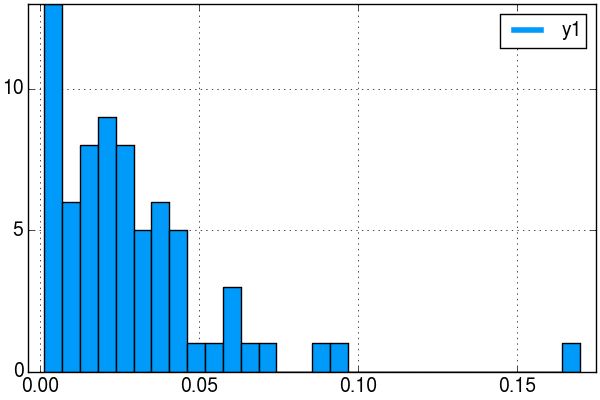

In [321]:
Plots.histogram(frame[:energies])


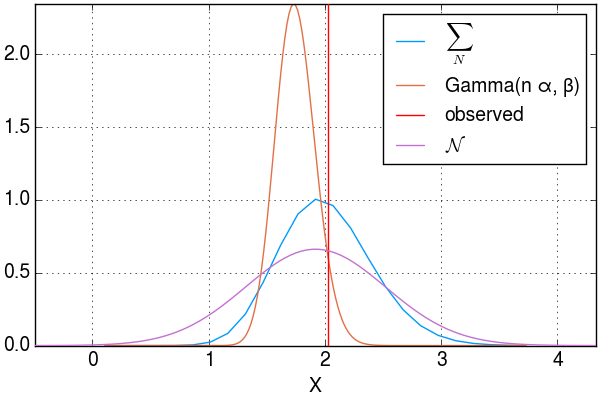

In [322]:
reload("Asymptotic")
asymp_res = Asymptotic.uncertainty(n, xmean, sumsqdiff, 0.)

compare(points, results, x; distn=distn)
Plots.plot!(distasympt, label=L"\mathcal{N}")